In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
df = pd.read_csv('CreditPrediction.csv').drop('Unnamed: 19', axis='columns')
print(df.shape)
df.head(10)

(10167, 19)


,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,45.0,M,3,High School,Married,$60K - $80K,Blue,39.0,5.0,1,3,12691.0,777,1.335,1144,42,1.625,0.061
1,818770008,49.0,F,5,Graduate,NaN,Less than $40K,Blue,44.0,6.0,1,2,8256.0,864,1.541,1291,33,3.714,0.105
2,713982108,51.0,M,3,Graduate,Married,$80K - $120K,Blue,36.0,4.0,1,0,3418.0,0,2.594,1887,20,2.333,0.000
3,769911858,40.0,F,4,High School,NaN,Less than $40K,Blue,34.0,3.0,4,1,3313.0,2517,1.405,1171,20,2.333,0.760
4,709106358,40.0,M,3,Uneducated,Married,$60K - $80K,NaN,21.0,5.0,1,0,4716.0,0,2.175,816,28,2.500,0.000
5,713061558,44.0,M,2,Graduate,Married,$40K - $60K,Blue,36.0,3.0,1,2,4010.0,1247,1.376,1088,24,0.846,0.311
6,810347208,51.0,M,4,Unknown,Married,$120K +,Gold,46.0,6.0,1,3,34516.0,2264,1.975,1330,31,0.722,0.066
7,818906208,32.0,M,0,High School,Unknown,$60K - $80K,Silver,27.0,2.0,2,2,29081.0,1396,2.204,1538,36,0.714,0.048
8,710930508,37.0,M,3,Uneducated,Single,$60K - $80K,NaN,36.0,5.0,2,0,22352.0,2517,3.355,1350,24,1.182,0.113
9,719661558,48.0,M,2,Graduate,Single,$80K - $120K,Blue,36.0,6.0,3,3,11656.0,1677,1.524,1441,32,0.882,0.144


In [3]:
# Drop Unwanted Columns
df = df.drop('CLIENTNUM', axis='columns') # Identifier, not typically used as a feature for analysis

In [4]:
# Remove Duplicated Rows
df.drop_duplicates(keep='first', inplace=True, ignore_index=True)
print(df.shape)

(10132, 18)


In [5]:
# Categorical columns
cat_col = [col for col in df.columns if df[col].dtype == 'object']
print('Categorical columns :',cat_col)
# Numerical columns
num_col = [col for col in df.columns if df[col].dtype != 'object']
print('Numerical columns :',num_col)

Categorical columns : ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
Numerical columns : ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


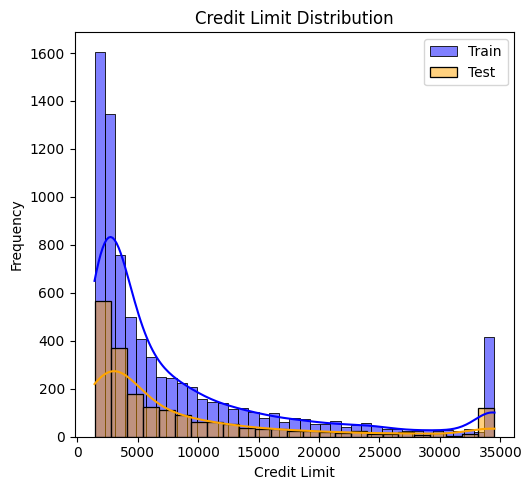

In [6]:
# Split the data
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

# Plot the distributions
plt.figure(figsize=(10, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(train_df['Credit_Limit'], kde=True, color='blue', label='Train')
sns.histplot(test_df['Credit_Limit'], kde=True, color='orange', label='Test')
plt.title('Credit Limit Distribution')
plt.xlabel('Credit Limit')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
nan_counts = train_df.isna().sum().sort_values(ascending=False)
summary = pd.concat([train_df.info(), nan_counts], axis=0)
summary

<class 'pandas.core.frame.DataFrame'>
Index: 8105 entries, 4984 to 7270
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              8105 non-null   float64
 1   Gender                    7947 non-null   object 
 2   Dependent_count           8105 non-null   int64  
 3   Education_Level           8105 non-null   object 
 4   Marital_Status            6576 non-null   object 
 5   Income_Category           8105 non-null   object 
 6   Card_Category             6586 non-null   object 
 7   Months_on_book            7921 non-null   float64
 8   Total_Relationship_Count  8087 non-null   float64
 9   Months_Inactive_12_mon    8105 non-null   int64  
 10  Contacts_Count_12_mon     8105 non-null   int64  
 11  Credit_Limit              8105 non-null   float64
 12  Total_Revolving_Bal       8105 non-null   int64  
 13  Total_Amt_Chng_Q4_Q1      8105 non-null   float64
 14  Total_Tran

Marital_Status              1529
Card_Category               1519
Months_on_book               184
Gender                       158
Total_Relationship_Count      18
Customer_Age                   0
Total_Revolving_Bal            0
Total_Ct_Chng_Q4_Q1            0
Total_Trans_Ct                 0
Total_Trans_Amt                0
Total_Amt_Chng_Q4_Q1           0
Months_Inactive_12_mon         0
Credit_Limit                   0
Contacts_Count_12_mon          0
Income_Category                0
Education_Level                0
Dependent_count                0
Avg_Utilization_Ratio          0
dtype: int64

In [8]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head()

,Total,%
Marital_Status,1529,18.9
Card_Category,1519,18.7
Months_on_book,184,2.3
Gender,158,1.9
Total_Relationship_Count,18,0.2


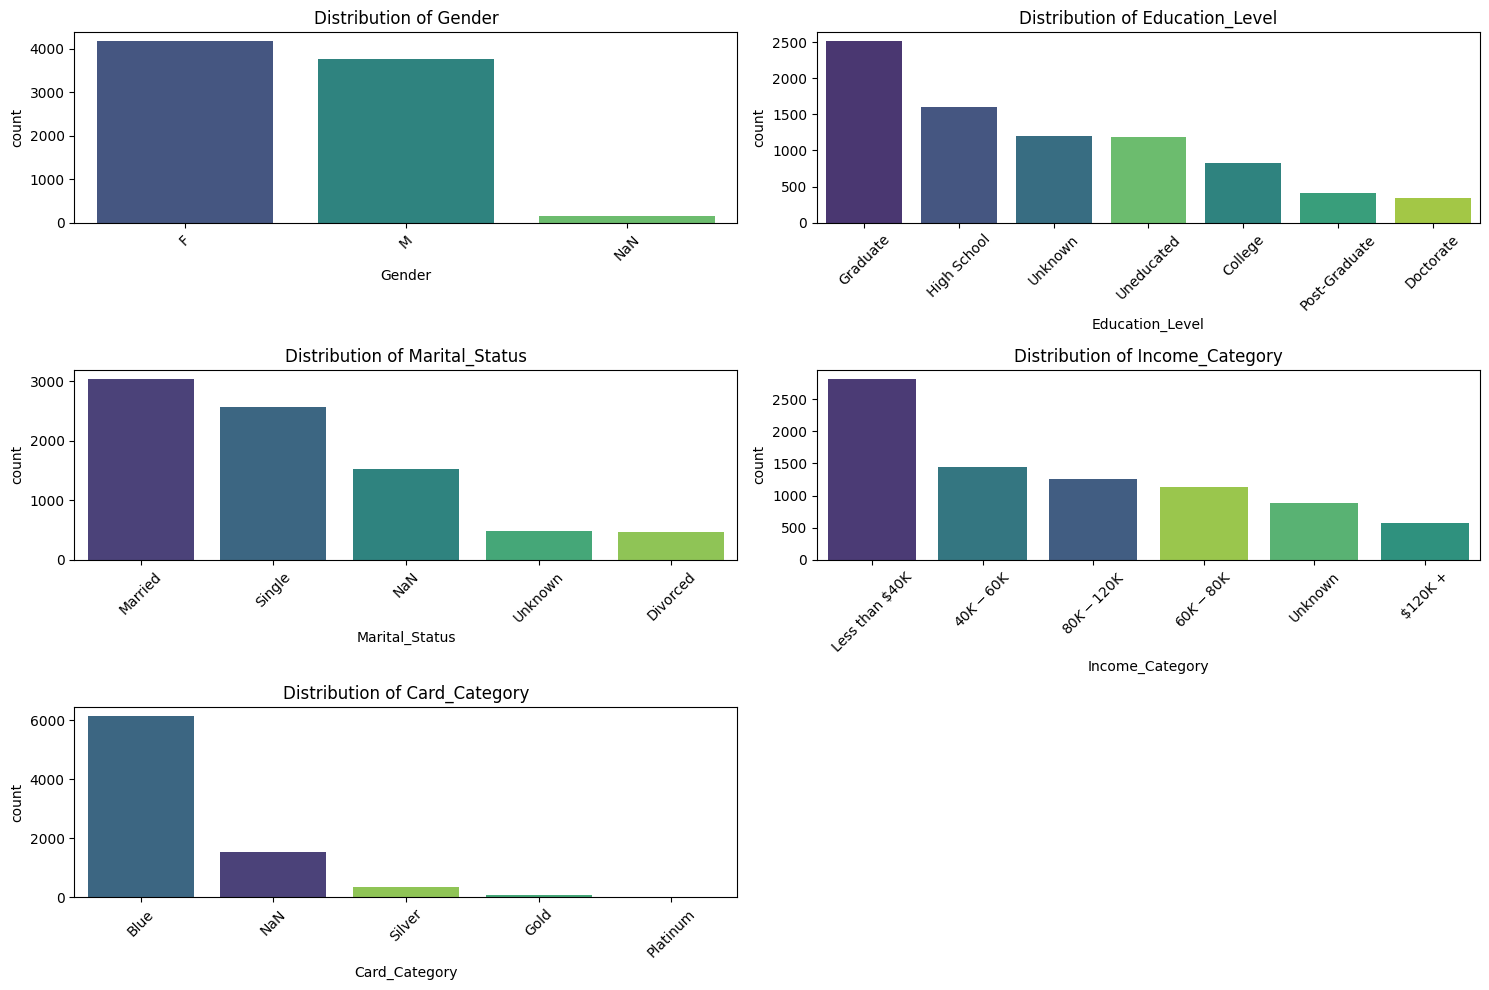

In [9]:
train_df_copy = train_df.copy()
categorical_features = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
train_df_copy[categorical_features] = train_df_copy[categorical_features].fillna('NaN')

# Plot bar plots for each categorical feature including NaN values
plt.figure(figsize=(15, 10))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=train_df_copy, x=feature, hue=feature, order=train_df_copy[feature].value_counts().index, palette="viridis", legend=False)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()

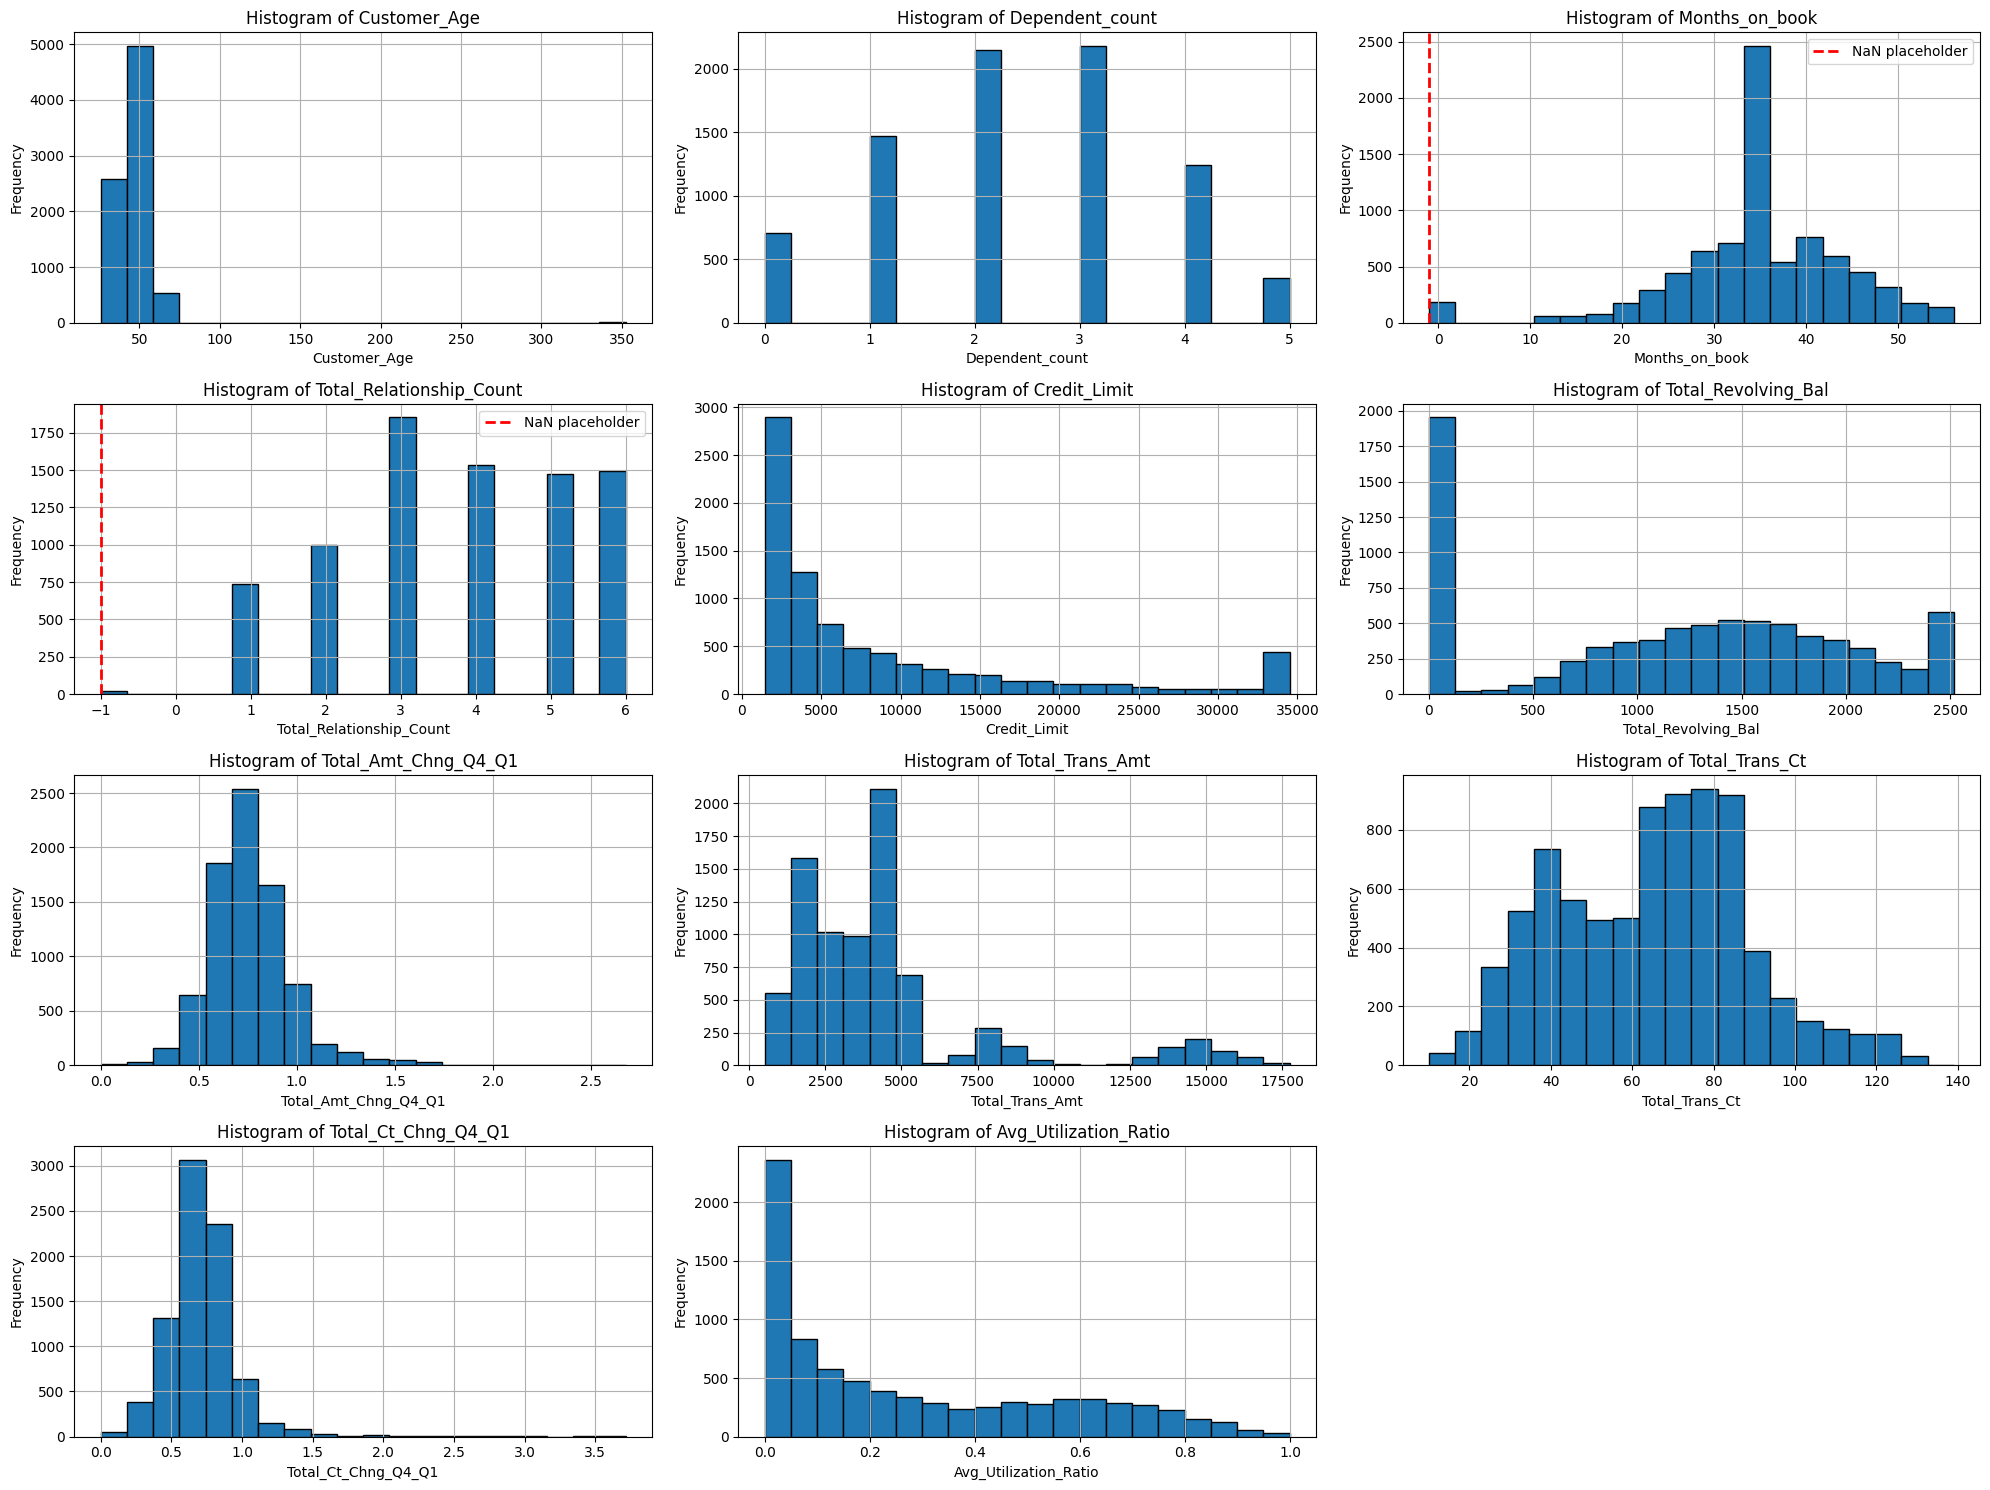

In [10]:
train_df_copy['Customer_Age'] = train_df_copy['Customer_Age'].fillna(-1)
train_df_copy['Months_on_book'] = train_df_copy['Months_on_book'].fillna(-1)
train_df_copy['Total_Relationship_Count'] = train_df_copy['Total_Relationship_Count'].fillna(-1)


numerical_features = ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
                      'Credit_Limit', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
                      'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

plt.figure(figsize=(20, 15))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(4, 3, i)
    train_df_copy[feature].hist(bins=20, edgecolor='black')
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    if -1 in train_df_copy[feature].values:
        plt.axvline(x=-1, color='red', linestyle='dashed', linewidth=2, label='NaN placeholder')
        plt.legend()

plt.tight_layout()
plt.show()

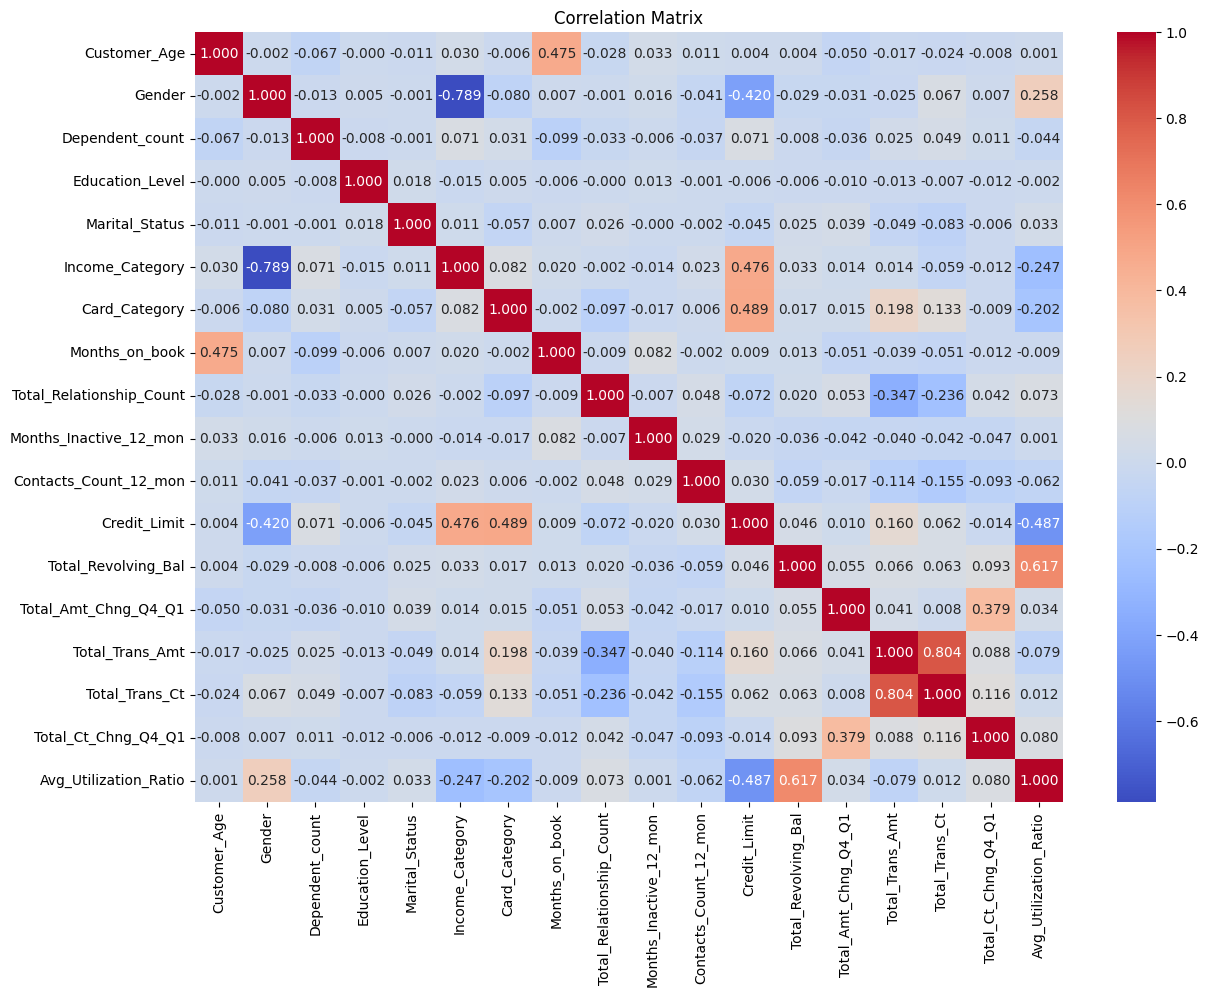

In [11]:
train_df_copy = train_df.copy()

# Define mappings for each categorical feature
gender_mapping = {'M': 0, 'F': 1}
education_mapping = {'Unknown': 0, 'Uneducated': 1, 'High School': 2, 'College': 3, 'Graduate': 4, 'Post-Graduate': 5, 'Doctorate': 6}
marital_mapping = {'Unknown': 0, 'Single': 1, 'Married': 2, 'Divorced': 3}
income_mapping = {'Unknown': 0, 'Less than $40K': 1, '$40K - $60K': 2, '$60K - $80K': 3, '$80K - $120K': 4, '$120K +': 5}
card_mapping = {'Blue': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3}

# Apply mapping to each categorical feature
train_df_copy['Gender'] = train_df_copy['Gender'].map(gender_mapping)
train_df_copy['Education_Level'] = train_df_copy['Education_Level'].map(education_mapping)
train_df_copy['Marital_Status'] = train_df_copy['Marital_Status'].map(marital_mapping)
train_df_copy['Income_Category'] = train_df_copy['Income_Category'].map(income_mapping)
train_df_copy['Card_Category'] = train_df_copy['Card_Category'].map(card_mapping)


correlation_matrix = train_df_copy.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Correlation Matrix')
plt.show()

In [12]:
# Imputation Gender

train_df['Gender'].describe()

count     7947
unique       2
top          F
freq      4173
Name: Gender, dtype: object

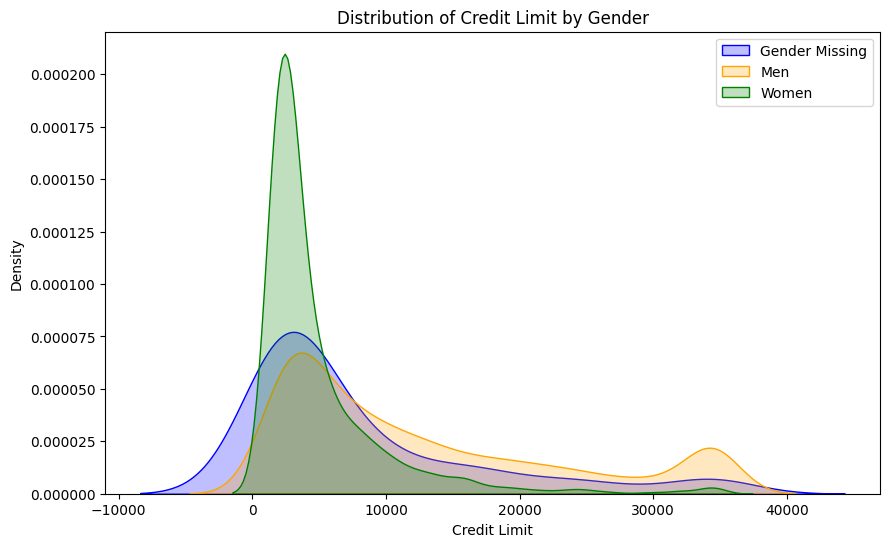

In [13]:
train_df_copy2 = train_df.copy()

df_nan_gender = train_df_copy2[train_df_copy2['Gender'].isna()]
df_men = train_df_copy2[(train_df_copy2['Gender'] == 'M') & train_df_copy2['Gender'].notna()]
df_women = train_df_copy2[(train_df_copy2['Gender'] == 'F') & train_df_copy2['Gender'].notna()]

# Plot KDE plots for credit limit distribution for all groups
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_nan_gender['Credit_Limit'], label='Gender Missing', fill=True, color='blue')
sns.kdeplot(data=df_men['Credit_Limit'], label='Men', fill=True, color='orange')
sns.kdeplot(data=df_women['Credit_Limit'], label='Women', fill=True, color='green')
plt.title('Distribution of Credit Limit by Gender')
plt.xlabel('Credit Limit')
plt.ylabel('Density')
plt.legend()
plt.show()

In [14]:
# Impute missing values in the 'Gender' column
train_df['Gender'] = train_df['Gender'].fillna('M')

In [15]:
# Encoding 

categorical_features = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']

gender_mapping = {'M': 0, 'F': 1}
education_mapping = {'Unknown': 0, 'Uneducated': 1, 'High School': 2, 'College': 3, 'Graduate': 4, 'Post-Graduate': 5, 'Doctorate': 6}
income_mapping = {'Unknown': 0, 'Less than $40K': 1, '$40K - $60K': 2, '$60K - $80K': 3, '$80K - $120K': 4, '$120K +': 5}
card_mapping = {'Blue': 1, 'Silver': 2, 'Gold': 3, 'Platinum': 4}
marital_mapping = {'Unknown': 1, 'Single': 2, 'Married': 3, 'Divorced': 4}


train_df['Gender'] = train_df['Gender'].map(gender_mapping)
train_df['Education_Level'] = train_df['Education_Level'].map(education_mapping)
train_df['Marital_Status'] = train_df['Marital_Status'].map(marital_mapping)
train_df['Income_Category'] = train_df['Income_Category'].map(income_mapping)
train_df['Card_Category'] = train_df['Card_Category'].map(card_mapping)

In [16]:
train_df.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
4984,52.0,1,3,4,3.0,1,NaN,39.0,4.0,3,3,2001.0,909,0.772,4238,63,0.800,0.454
3550,52.0,1,2,2,2.0,1,1.0,40.0,3.0,1,3,1960.0,1428,0.570,3782,64,0.641,0.729
1937,34.0,0,2,4,NaN,4,1.0,29.0,3.0,1,3,13395.0,1678,1.006,2650,69,0.865,0.125
4480,50.0,1,4,2,3.0,2,1.0,36.0,6.0,1,1,1479.0,1004,0.827,5116,75,0.974,0.679
8553,50.0,1,3,2,2.0,1,1.0,42.0,1.0,3,2,1477.0,0,0.685,4680,80,0.778,0.000


In [17]:
# Imputation Total_Relationship_Count & Months_on_book

features_for_imputation = ['Total_Relationship_Count', 'Months_on_book']

imputer = KNNImputer(n_neighbors=5)

train_df[features_for_imputation] = imputer.fit_transform(train_df[features_for_imputation])

In [18]:
# Imputation Marital_Status Card_Category

features_for_imputation = ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
                           'Credit_Limit', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
                           'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
                           'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Gender']

# Initialize IterativeImputer with a linear regression estimator
regressor = LinearRegression()
imp = IterativeImputer(estimator=regressor, missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman')

# Fit and transform the imputer on the selected features
train_df[features_for_imputation] = imp.fit_transform(train_df[features_for_imputation])

[IterativeImputer] Completing matrix with shape (8105, 16)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.10
[IterativeImputer] Change: 0.8290678232424968, scaled tolerance: 34.516 
[IterativeImputer] Early stopping criterion reached.


In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8105 entries, 4984 to 7270
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              8105 non-null   float64
 1   Gender                    8105 non-null   float64
 2   Dependent_count           8105 non-null   float64
 3   Education_Level           8105 non-null   float64
 4   Marital_Status            8105 non-null   float64
 5   Income_Category           8105 non-null   float64
 6   Card_Category             8105 non-null   float64
 7   Months_on_book            8105 non-null   float64
 8   Total_Relationship_Count  8105 non-null   float64
 9   Months_Inactive_12_mon    8105 non-null   int64  
 10  Contacts_Count_12_mon     8105 non-null   int64  
 11  Credit_Limit              8105 non-null   float64
 12  Total_Revolving_Bal       8105 non-null   float64
 13  Total_Amt_Chng_Q4_Q1      8105 non-null   float64
 14  Total_Tran

In [20]:
train_df.describe()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,8105.000000,8105.000000,8105.000000,8105.000000,8105.000000,8105.000000,8105.000000,8105.000000,8105.000000,8105.000000,8105.000000,8105.000000,8105.000000,8105.000000,8105.000000,8105.00000,8105.000000,8105.000000
mean,46.795802,0.514867,2.349291,2.600864,2.533696,2.094139,1.084865,35.865959,3.802838,2.341888,2.455398,8602.754127,1166.640592,0.759599,4417.966440,64.99013,0.711974,0.276807
std,14.377782,0.499810,1.297739,1.691823,0.663721,1.474327,0.314248,7.910089,1.555536,1.007721,1.100913,9051.970024,814.016266,0.216736,3397.459451,23.47509,0.238704,0.275700
min,26.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.804819,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,0.000000,510.000000,10.00000,0.000000,0.000000
25%,41.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,32.000000,3.000000,2.000000,2.000000,2537.000000,451.000000,0.631000,2164.000000,45.00000,0.583000,0.026000
50%,46.000000,1.000000,2.000000,3.000000,2.563936,2.000000,1.000000,36.000000,4.000000,2.000000,2.000000,4552.000000,1279.000000,0.736000,3913.000000,68.00000,0.702000,0.178000
75%,52.000000,1.000000,3.000000,4.000000,3.000000,3.000000,1.000000,40.000000,5.000000,3.000000,3.000000,11062.000000,1785.000000,0.859000,4751.000000,81.00000,0.818000,0.507000
max,352.330517,1.000000,5.000000,6.000000,4.000000,5.000000,4.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,2.675000,17744.000000,139.00000,3.714000,0.999000


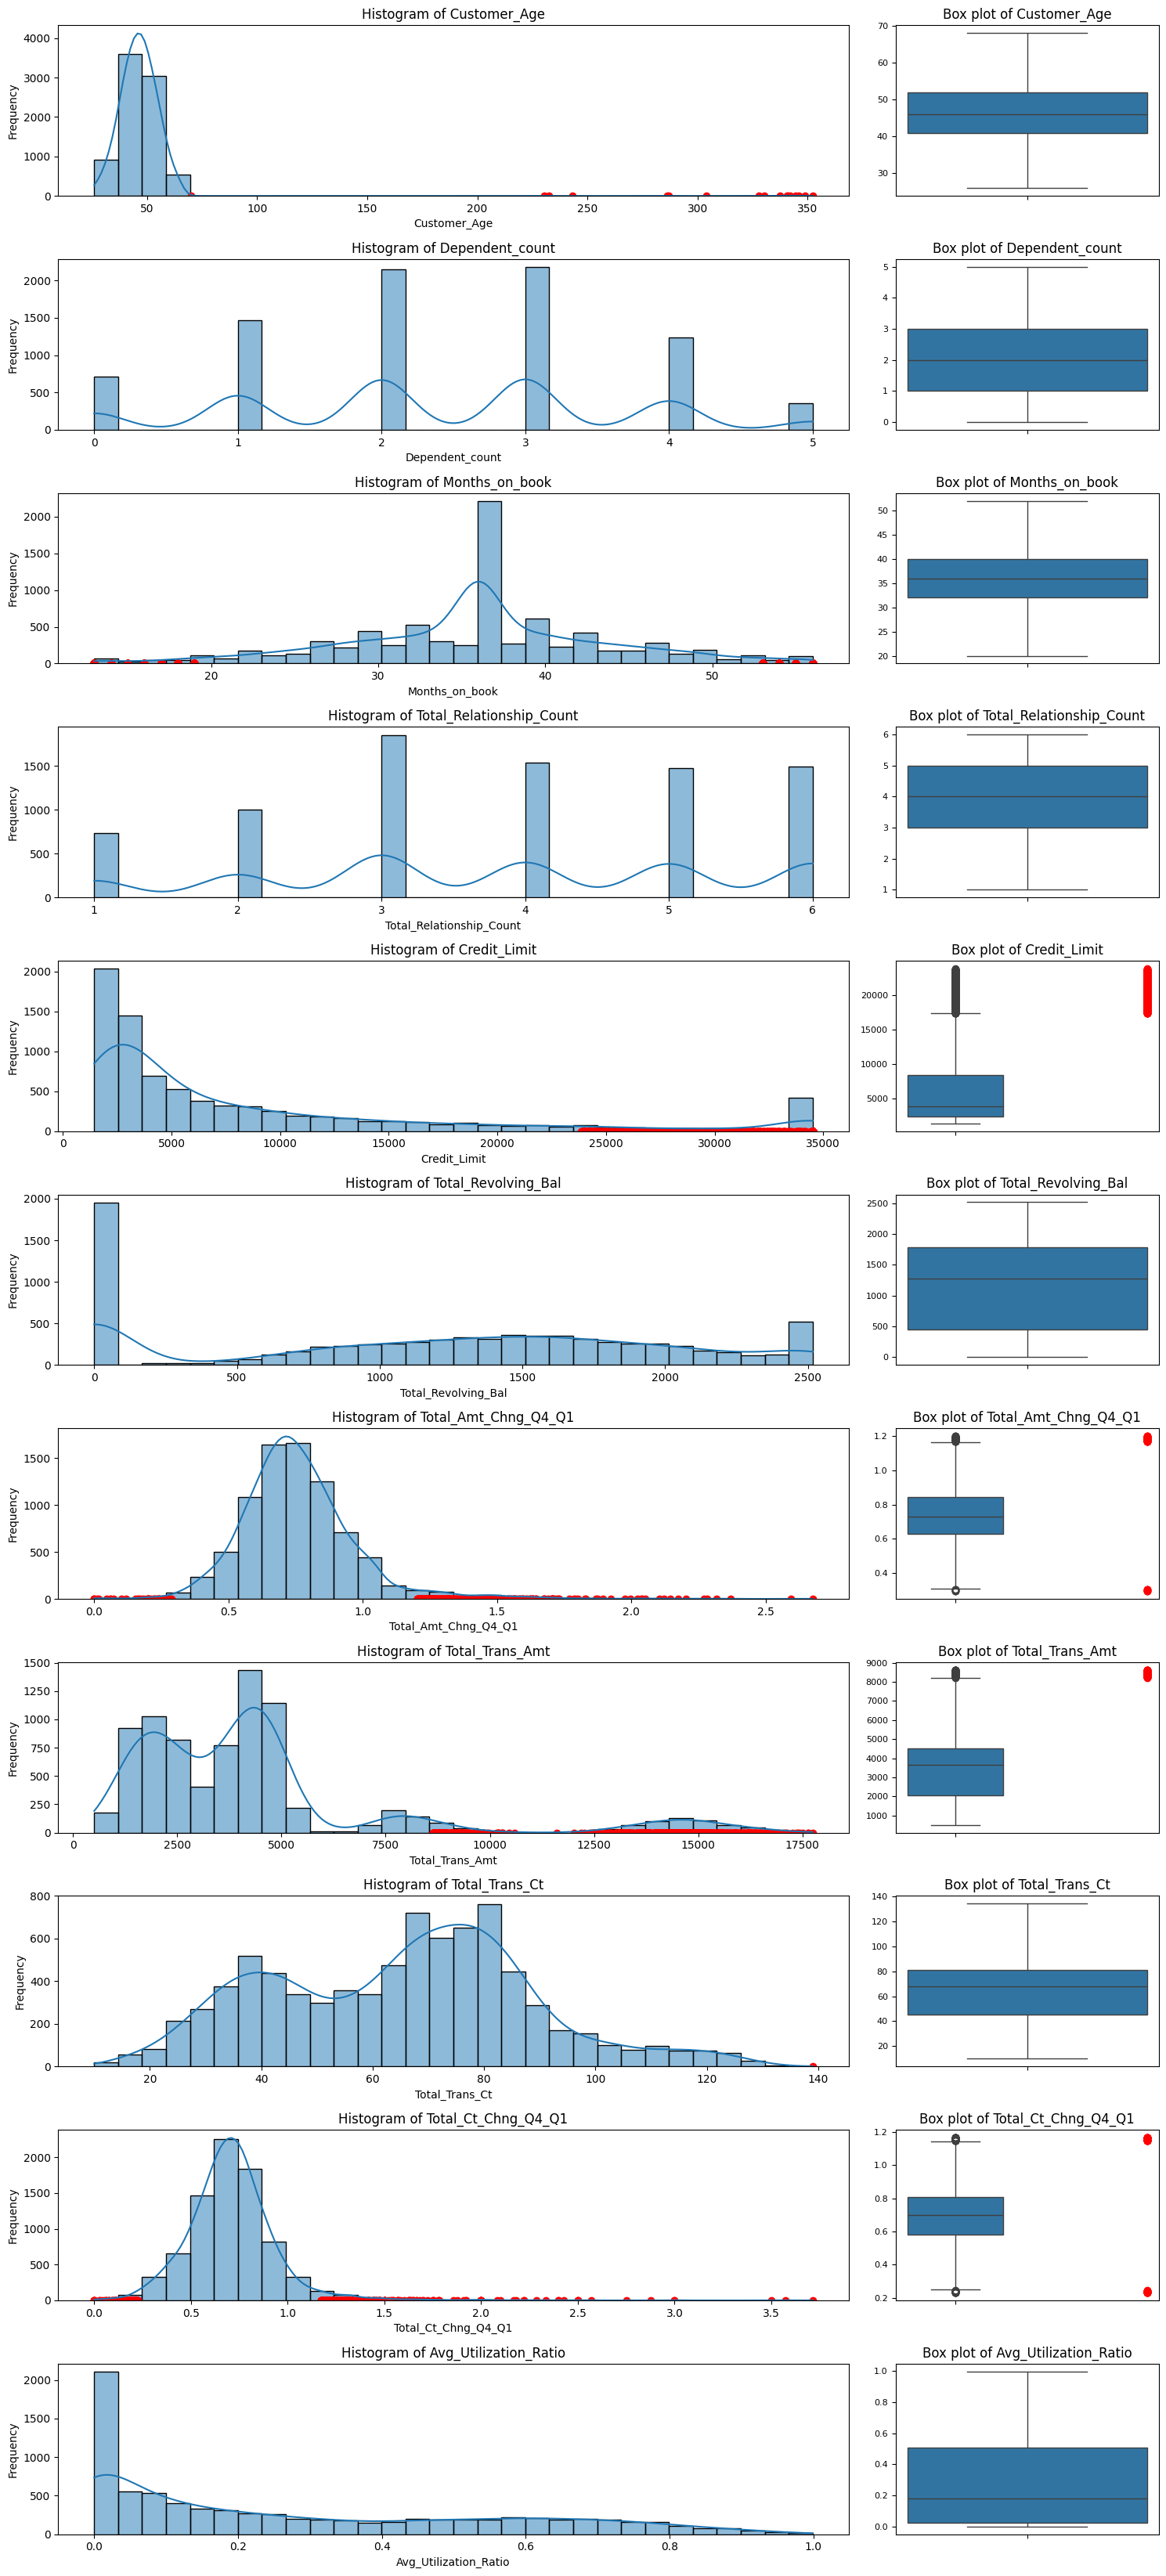

In [21]:
numeric_columns = ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
                   'Credit_Limit', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
                   'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
                   ]


fig, axes = plt.subplots(nrows=len(numeric_columns), ncols=2, figsize=(15, 3*len(numeric_columns)), gridspec_kw={'width_ratios': [3, 1]})

# Plot histograms
for i, feature in enumerate(numeric_columns):
    sns.histplot(train_df[feature], bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {feature}')
    axes[i, 0].set_xlabel(feature)
    axes[i, 0].set_ylabel('Frequency')

    # Detect and mark outliers using histogram
    q1 = train_df[feature].quantile(0.25)
    q3 = train_df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = train_df[(train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)]
    axes[i, 0].scatter(outliers[feature], [0] * len(outliers), color='red', label='Outliers')
    train_df.loc[(train_df[feature] < lower_bound) | (train_df[feature] > upper_bound), feature] = np.nan

# Plot box plots 
for i, feature in enumerate(numeric_columns):
    sns.boxplot(data=train_df, y=feature, ax=axes[i, 1], orient='v', width=0.5)
    axes[i, 1].set_title(f'Box plot of {feature}')
    axes[i, 1].set_ylabel('')
    axes[i, 1].set_xlabel('')
    axes[i, 1].tick_params(axis='y', labelsize=8)

    # Detect and mark outliers using box plot
    q1 = train_df[feature].quantile(0.25)
    q3 = train_df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = train_df[(train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)]
    axes[i, 1].scatter([1] * len(outliers), outliers[feature], color='red', label='Outliers')

plt.tight_layout()
plt.show()


In [22]:
# Detect ages greater than 125 and set them to NaN
train_df['Customer_Age'] = train_df['Customer_Age'].apply(lambda x: np.nan if x > 125 else x)

# Impute the missing values
imputer = SimpleImputer(strategy='mean')
train_df['Customer_Age'] = imputer.fit_transform(train_df[['Customer_Age']])

In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8105 entries, 4984 to 7270
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              8105 non-null   float64
 1   Gender                    8105 non-null   float64
 2   Dependent_count           8105 non-null   float64
 3   Education_Level           8105 non-null   float64
 4   Marital_Status            8105 non-null   float64
 5   Income_Category           8105 non-null   float64
 6   Card_Category             8105 non-null   float64
 7   Months_on_book            7649 non-null   float64
 8   Total_Relationship_Count  8105 non-null   float64
 9   Months_Inactive_12_mon    8105 non-null   int64  
 10  Contacts_Count_12_mon     8105 non-null   int64  
 11  Credit_Limit              7325 non-null   float64
 12  Total_Revolving_Bal       8105 non-null   float64
 13  Total_Amt_Chng_Q4_Q1      7784 non-null   float64
 14  Total_Tran

In [24]:
features_for_imputation = ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
                           'Credit_Limit', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
                           'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
                           'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Gender']

# Initialize IterativeImputer with a linear regression estimator
regressor = LinearRegression()
imp = IterativeImputer(estimator=regressor, missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman')

# Fit and transform the imputer on the selected features
train_df[features_for_imputation] = imp.fit_transform(train_df[features_for_imputation])

[IterativeImputer] Completing matrix with shape (8105, 16)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.07
[IterativeImputer] Change: 30253.18378944209, scaled tolerance: 23.848 
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.11
[IterativeImputer] Change: 51.886922026604225, scaled tolerance: 23.848 
[IterativeImputer] Ending imputation round 3/10, elapsed time 0.17
[IterativeImputer] Change: 24.35122548372425, scaled tolerance: 23.848 
[IterativeImputer] Ending imputation round 4/10, elapsed time 0.23
[IterativeImputer] Change: 17.8797254833826, scaled tolerance: 23.848 
[IterativeImputer] Early stopping criterion reached.


In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8105 entries, 4984 to 7270
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              8105 non-null   float64
 1   Gender                    8105 non-null   float64
 2   Dependent_count           8105 non-null   float64
 3   Education_Level           8105 non-null   float64
 4   Marital_Status            8105 non-null   float64
 5   Income_Category           8105 non-null   float64
 6   Card_Category             8105 non-null   float64
 7   Months_on_book            8105 non-null   float64
 8   Total_Relationship_Count  8105 non-null   float64
 9   Months_Inactive_12_mon    8105 non-null   int64  
 10  Contacts_Count_12_mon     8105 non-null   int64  
 11  Credit_Limit              8105 non-null   float64
 12  Total_Revolving_Bal       8105 non-null   float64
 13  Total_Amt_Chng_Q4_Q1      8105 non-null   float64
 14  Total_Tran

In [26]:
scaler = MinMaxScaler()
x_train_df = scaler.fit_transform(train_df.drop('Credit_Limit', axis='columns')) 

In [27]:
type(x_train_df)

numpy.ndarray

In [28]:
test_df['Gender'] = test_df['Gender'].map(gender_mapping)
test_df['Education_Level'] = test_df['Education_Level'].map(education_mapping)
test_df['Marital_Status'] = test_df['Marital_Status'].map(marital_mapping)
test_df['Income_Category'] = test_df['Income_Category'].map(income_mapping)
test_df['Card_Category'] = test_df['Card_Category'].map(card_mapping)


features_for_imputation = ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
                           'Credit_Limit', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
                           'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
                           'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Gender']

# Initialize IterativeImputer with a linear regression estimator
regressor = LinearRegression()
imp = IterativeImputer(estimator=regressor, missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman')

# Fit and transform the imputer on the selected features
test_df[features_for_imputation] = imp.fit_transform(test_df[features_for_imputation])


x_test_df = scaler.transform(test_df.drop('Credit_Limit', axis='columns'))

[IterativeImputer] Completing matrix with shape (2027, 16)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.03
[IterativeImputer] Change: 11.385690567284286, scaled tolerance: 34.516 
[IterativeImputer] Early stopping criterion reached.


In [29]:
x_test_df

array([[0.52380952, 1.17701103, 0.6       , ..., 0.51612903, 0.36645299,
        0.58758759],
       [0.4047619 , 0.        , 0.6       , ..., 0.47580645, 0.39957265,
        0.16016016],
       [0.57142857, 0.        , 0.2       , ..., 0.59677419, 0.37820513,
        0.09409409],
       ...,
       [0.45238095, 0.        , 0.8       , ..., 0.69354839, 0.45299145,
        0.22322322],
       [0.66666667, 0.        , 0.6       , ..., 0.44354839, 0.30021368,
        0.08508509],
       [0.45238095, 1.        , 0.4       , ..., 0.25806452, 0.41025641,
        0.82982983]])

In [30]:
x_test = x_test_df
y_test = test_df['Credit_Limit']

x_train = x_train_df
y_train = train_df['Credit_Limit']

In [31]:
# Create an instance of the LinearRegression model
regr = LinearRegression()

# Fit the model on the training data
regr.fit(x_train, y_train)

# Predict the target variable for the test data
predicted = regr.predict(x_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, predicted)
print("Mean Squared Error:", mse)

# Calculate the R-squared score
r2 = r2_score(y_test, predicted)
print("R-squared Score:", r2)

print("score : ", regr.score(x_train, y_train))

# Retrieve the coefficients and intercept
coefficients = regr.coef_
intercept = regr.intercept_

#Print the coefficients and intercept
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Mean Squared Error: 43018338.29056761
R-squared Score: 0.4946712721092251
score :  0.6731110498836831
Coefficients: [   549.01032932   -934.86849889    195.9895731     -72.64484646
   -381.63336918   2820.15653807  17485.3652202    -510.53527034
    488.91539602    121.78280411     46.23056819   9459.87652543
    198.49355921    237.27653002    377.93738209    136.78118758
 -15186.21818708]
Intercept: 3943.8315852307255


In [32]:
# Initialize Ridge Regression model
ridge_reg = Ridge(alpha=0.9)  

# Train the model
ridge_reg.fit(x_train, y_train)

# Make predictions
y_pred = ridge_reg.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

r2 = r2_score(y_test, predicted)
print("R-squared Score:", r2)

Mean Squared Error: 43089014.274958685
R-squared Score: 0.4946712721092251


In [33]:
# Initialize MLPRegressor model
mlp_reg = MLPRegressor(hidden_layer_sizes=(100, 25), activation='relu', solver='adam', max_iter=1000, random_state=42)

# Train the model
mlp_reg.fit(x_train, y_train)

# Make predictions
y_pred = mlp_reg.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

r2 = r2_score(y_test, predicted)
print("R-squared Score:", r2)

Mean Squared Error: 31195472.95992762
R-squared Score: 0.4946712721092251


D:\Python\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
